# Нейронный перенос стиля с Pytorch: реализуем как перенос двух стилей одновременно, так и частичный перенос стиля -- одна часть картинки обрабатывается стилем 1, а другая --  стилем 2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

## Загрузка изображений

Загрузим два стилевых изображения и изображение контента (фотография дельфин Форест в роли Аксиньи).
Художники -- Фрида Кало ("Автопортрет") и Карлос Вандерлей Пинто ("Девушки весной")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# напишем загрузчик
def image_loader(image_name, imsize):
    # приводим картинку к нужному нам размеру, переводим в тензор
    loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])
    # загружаем
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# загружаем 2 стилевых файла
style1_img = image_loader("girls.jpg", 128)
style2_img = image_loader("frida.jpg", 128)
# загружаем контент
content_img = image_loader("aksiniya.jpg", 128)

Выведем то, что было загружено

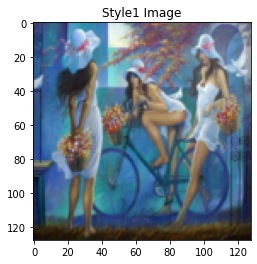

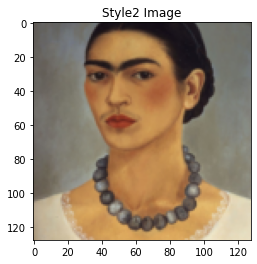

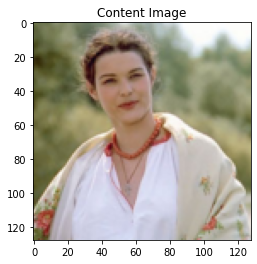

In [ ]:
# тензор в картинку  
unloader = transforms.ToPILImage() 

plt.ion() 
# функция для отрисовки изображения
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style1_img, title='Style1 Image')

plt.figure()
imshow(style2_img, title='Style2 Image')

plt.figure()
imshow(content_img, title='Content Image')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

## Реализуем Content Loss

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # это константа. Убираем ее из дерева вычислений
            self.target = target.detach()
            # инициализируем лосс
            self.loss = F.mse_loss(self.target, self.target )

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

## Построим функцию, вычисляющую т.н. матрицу Грама 

Матрица Грама позволяет учесть не только сами значения feature map'а, но и корреляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />


Таким образом,

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы Грама: это просто тензорное тензорное произведение вектора выхода самого на себя.<br /> Однако наш выход -- не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [ ]:
def gram_matrix(input):
        # Второй параметр -- число feature maps
        # (h,w) -- это размеры фича мапы (N=h*w)
        batch_size, f_map_num, h, w = input.size()  # batch size(=1)
        features = input.view(batch_size*f_map_num, h*w)  # преобразуем выход в вектор
        G = torch.mm(features, features.t())  # вычисляем ненормированную матрицу Грама

        # нормализуем элементы матрицы Грама, поделив на число элементов в каждой фича мапе
    
        return G.div(batch_size * h * w * f_map_num)

## Напишем функцию для создания и загрузки разных типов масок: я сделала и протестировала диагональную, ветикальную, горизонтальную маски и маску в форме пятна с неровными краями. (Все масочные файлы лежат в папке "Styles & masks"). Вы можете добавить какую-нибудь свою :=))

## * ВНИМАНИЕ ! В качестве маски можно использовать только монохромные файлы формата .bmp *

In [ ]:
# "Универсальная масочная функция". Работает быстрее написанных вручную масок, т.к. тензор маски не создается
# каждый раз с нуля
def masky(input, mask_type):
    _, f, h, _ = input.size()
    # загружаем файл с маской
    maskf = image_loader(mask_type+".bmp", h)
    mask = torch.tensor(np.array(maskf > 0.5, np.float32))
    # стакаем маску по числу фича-мапов у инпута          
    mask = mask.repeat(1, f, 1, 1)
    return mask
    return mask

# создаем зеркальную ей маску для применения второго стиля
def masky_dual(input, mask_type):
    _, f, h, _ = input.size()
    maskf = image_loader(mask_type+".bmp", h)
    mask = torch.tensor(np.array(maskf < 0.5, np.float32))           
    mask = mask.repeat(1, f, 1, 1)
    return mask

## Реализуем Style Loss

In [ ]:

class StyleLoss(nn.Module):
        def __init__(self, target_feature, style, option, mask_type = None):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.style = style
            self.option = option
            self.mask_type = mask_type
            # инициализируем лосс
            self.loss = F.mse_loss(self.target, self.target)

        def forward(self, input):
            # прописываем применение выбранной маски и подсчет лосса 
            # для переноса разных стилей на разные части картинки 
            # (т.н. partial_style_transfer)
            if self.option == 'partial_style':
                if self.style == 1:
                    mask = masky(input, self.mask_type)
                elif self.style == 2:
                    mask = masky_dual(input, self.mask_type)     
                else:
                    raise RuntimeError('Incorrect style initialiation: {}'.format(self.style))     
                input1 = input.clone()
                input2 = input1 * mask
                G = gram_matrix(input2)
                self.loss = F.mse_loss(G, self.target)
            # прописываем подсчет лосса для одновременного переноса двух стилей 
            # на всю картинку 
            # (т.н. dual style transfer)
            elif self.option == 'dual_style':
                G = gram_matrix(input)
                self.loss = F.mse_loss(G, self.target) 
            else:
                raise RuntimeError('Unknown option for style: {}'.format(self.option))  
            return input

При тренировке VGG каждое изображение, на котором она обучалась, было нормировано по всем каналам (RGB). Если мы хотим использовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view среднее и стандартное отклонение к виду  [C x 1 x 1], чтобы
            # мы смогли вычислить их для стандартного тензора вида [B x C x H x W].
           
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # нормализуем картинку
            return (img - self.mean) / self.std

## Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим, после каких уровней мы будем считать ошибки стиля, а после каких  -- ошибки контента

Зададим предобученную модель

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
# мы ее не обучаем, она работает только в режиме предсказания

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img, option, mask_type): 
        content_layers= ['conv_4']
        style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        cnn = copy.deepcopy(cnn)
        global style
        content_losses = []
        style_losses1 = []
        style_losses2 = []
        # добавим в модель модуль нормализации
        normalization = Normalization(normalization_mean, normalization_std).to(device)
        model = nn.Sequential(normalization)

        i = 0  # переменная для подсчета сверточных слоев
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # Переопределим Relu уровень 
                # для корректной работы со стилевыми слоями
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # добавляем в модель слой  content loss-а:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
            # добавляем в модель слои style loss-ов:
            if name in style_layers:
                # если мы осуществляем перенос разных стилей на разные части картинки,
                # то введем переменную style, которая будет определять, с какой именно
                # частью картинки мы работаем -- первый стилевой слой используется 
                # для одной части изображения, а второй стилевой слой -- для другой.
                # Соответствующие части картинки выделяются маской
                # (так что здесь мы еще указываем и тип маски)
                if option == 'partial_style':
                    # добавили первый слой 
                    style = 1 # режим первого стиля
                    target_feature1 = model(style1_img).detach()
                    style_loss1 = StyleLoss(target_feature1, style, option, mask_type)
                    model.add_module("style_loss1_{}".format(i), style_loss1)
                    style_losses1.append(style_loss1)
                    
                    # добавили второй слой
                    style = 2 # режим второго стиля
                    target_feature2 = model(style2_img).detach()
                    style_loss2 = StyleLoss(target_feature2, style, option, mask_type)
                    model.add_module("style_loss2_{}".format(i), style_loss2)
                    style_losses2.append(style_loss2)
                # если же мы осуществляем одновременный перенос двух стилей на всю картинку,
                # просто создаем 2 стилевых слоя и последовательно  прогоняем  
                # наше изображение целиком через оба слоя.
                # маска нам здесь больше не нужна, и мы ее даже не инициализируем.
                # Переменная style тоже не нужна, и мы ее зануляем
                elif option == 'dual_style':
                    style = 0 # одновременный стилевой режим
                    # добавили первый слой
                    target_feature1 = model(style1_img).detach()
                    style_loss1 = StyleLoss(target_feature1, style, option)
                    model.add_module("style_loss1_{}".format(i), style_loss1)
                    style_losses1.append(style_loss1)

                    # добавили второй слой
                    target_feature2 = model(style2_img).detach()
                    style_loss2 = StyleLoss(target_feature2, style, option)
                    model.add_module("style_loss2_{}".format(i), style_loss2)
                    style_losses2.append(style_loss2)
                else:
                    raise RuntimeError('Unrecognized style: {}'.format(option))

        #выбрасываем все уровни VGG-ки после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses1, style_losses2, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # добавляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [ ]:
# для отрисовки графиков обучения
style1_loss = []
style2_loss = []
content_loss = []

## Пишем функцию обучения модели 
Она реализует стандартный цикл обучения, но мы добавляем функцию closure.
Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется, так как у нас своя -- не библиотечная --  функция ошибки

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        input_img, style1_img, style2_img, content_img, mask_type, num_steps=750,
                        style_weight1=100000, style_weight2=100000, content_weight=1, 
                        option = 'partial_style'):
        print('Building the style transfer model..')
        model, style_losses1, style_losses2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img, option, mask_type)
        optimizer = get_input_optimizer(input_img)
        eps = 1e-9
        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(eps, 1-eps)
                # обнуляем градиент
                optimizer.zero_grad()

                # прогоняем картинку через модель
                model(input_img)

                # считаем лоссы
                style_score1 = 0
                style_score2 = 0
                content_score = 0

                for sl in style_losses1:
                    style_score1 += sl.loss
                
                for sl in style_losses2:
                    style_score2 += sl.loss

                for cl in content_losses:
                    content_score += cl.loss
                
                # взвешивание ошибки в зависимости от типа обработки картинки
                if option == 'partial_style':
                    style_score1 *= style_weight1
                    style_score2 *= style_weight1
                    content_score *= content_weight
                elif option == 'dual_style':
                    style_score1 *= style_weight1
                    style_score2 *= 0.7 * style_weight2
                    content_score *= content_weight
                else:
                    raise RuntimeError('Unrecognized style: {}'.format(option))
                # строим лосс
                loss = style_score1 + style_score2 + content_score
                # и вычисляем по нему градиент
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss1 : {:4f} Style Loss2 : {:4f} Content Loss: {:4f}'.format(
                        style_score1.item(), style_score2.item(), content_score.item()))
                    print()
                style1_loss.append(style_score1.item())
                style2_loss.append(style_score2.item())
                content_loss.append(content_score.item())

                return style_score1 + style_score2 + content_score
            # шаг градиентного спуска
            optimizer.step(closure)

        # еще раз корректируем картинку
        input_img.data.clamp_(eps, 1-eps)

        return input_img

## Тестируем перенос стиля на наших картинках

### Диагональная маска

ВНИМАНИЕ! В качестве параметра mask_type указываем **имя файла с маской до расширения** (в кавычках), т.е. если файл был diag.bmp, то mask_type = 'diag'

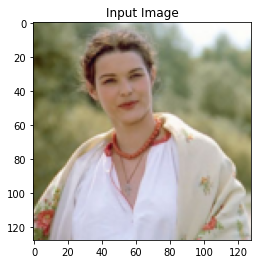

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 44.082630 Style Loss2 : 19.969103 Content Loss: 32.491409

run [100]:
Style Loss1 : 12.868015 Style Loss2 : 10.163231 Content Loss: 29.720531

run [150]:
Style Loss1 : 10.133709 Style Loss2 : 7.436670 Content Loss: 28.340145

run [200]:
Style Loss1 : 8.792667 Style Loss2 : 6.138289 Content Loss: 27.583855

run [250]:
Style Loss1 : 8.086676 Style Loss2 : 5.418886 Content Loss: 27.024776

run [300]:
Style Loss1 : 7.903063 Style Loss2 : 5.093524 Content Loss: 26.629261

run [350]:
Style Loss1 : 7.470150 Style Loss2 : 4.889997 Content Loss: 26.468437



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# вывод исходной картинки
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, num_steps=350,option = 'partial_style',
                            mask_type='diag')

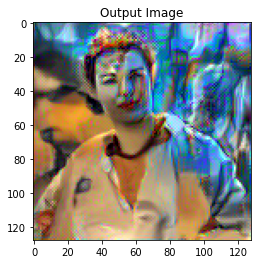

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

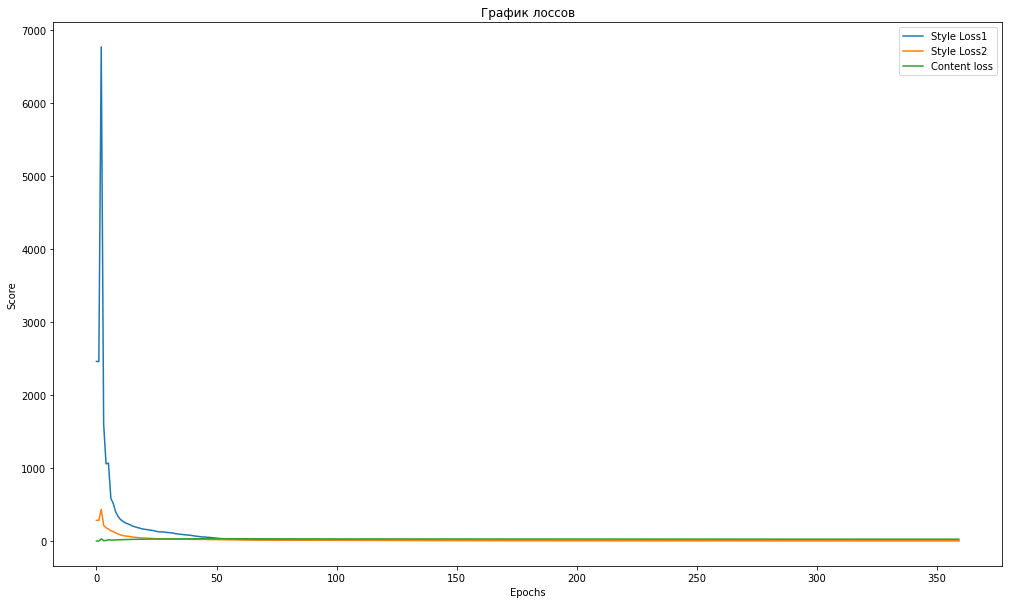

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

Несмотря на то, что на графике мы весьма рано начинаем наблюдать сходимость, увеличение числа эпох зачастую нужно для улучшения качества выходного изображения, но обучать лучше до появления пиков у лоссов (с маленьким числом эпох -- даже без пиков -- качество похуже). Но и при слишком большом количестве эпох модель "ломается" и выдает каляки-маляки, без контуров, осоенно если лосс стал выдавать пики))

UPD: Подбор числа эпох и весов очень сильно зависит от стилевых картинок и картинки-контента, а также наших эстетических предпочтений. И даже от типа маски!

### Горизонтальная маска
ВНИМАНИЕ! В качестве параметра mask_type указываем имя файла с маской до расширения (в кавычках), т.е. если файл был hor.bmp, то mask_type = 'hor'

In [ ]:
# для отрисовки графиков обучения
style1_loss = []
style2_loss = []
content_loss = []

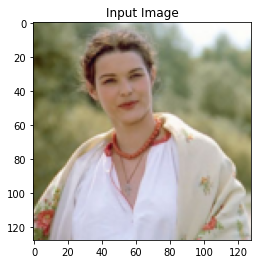

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 43.674656 Style Loss2 : 25.607601 Content Loss: 49.888626

run [100]:
Style Loss1 : 13.444547 Style Loss2 : 10.133616 Content Loss: 43.103439

run [150]:
Style Loss1 : 10.564981 Style Loss2 : 6.860132 Content Loss: 38.072151

run [200]:
Style Loss1 : 9.203486 Style Loss2 : 5.572292 Content Loss: 34.874546

run [250]:
Style Loss1 : 8.508764 Style Loss2 : 4.987581 Content Loss: 32.681625

run [300]:
Style Loss1 : 8.023814 Style Loss2 : 4.651633 Content Loss: 31.248875

run [350]:
Style Loss1 : 7.700468 Style Loss2 : 4.474705 Content Loss: 30.272736



In [ ]:
input_img = content_img.clone()
# вывод исходной картинки
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, num_steps=350, option = 'partial_style',
                            mask_type='hor')

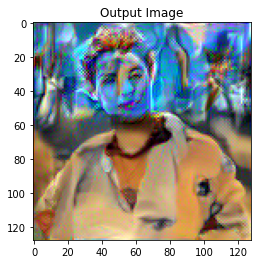

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

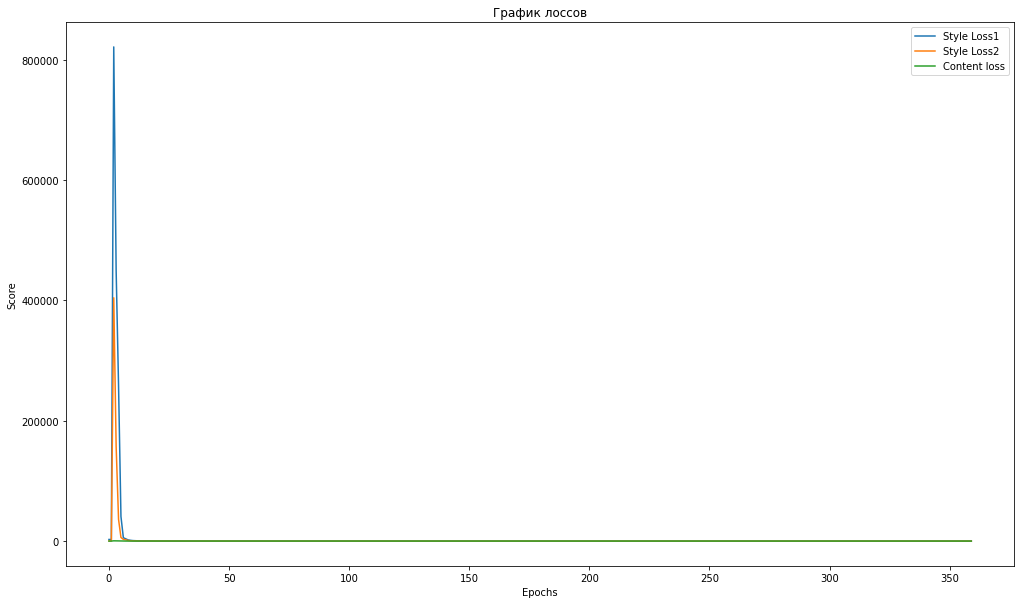

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

### Вертикальная маска

ВНИМАНИЕ! В качестве параметра mask_type указываем имя файла с маской до расширения (в кавычках), т.е. если файл был vert.bmp, то mask_type = 'vert'

In [ ]:
# для отрисовки графиков обучения
style1_loss = []
style2_loss = []
content_loss = []

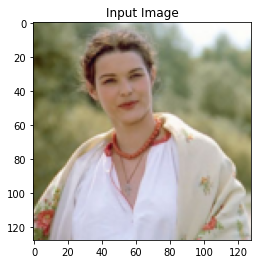

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 37.372807 Style Loss2 : 19.420147 Content Loss: 31.416367

run [100]:
Style Loss1 : 13.541068 Style Loss2 : 9.914309 Content Loss: 28.344826

run [150]:
Style Loss1 : 10.362614 Style Loss2 : 6.804817 Content Loss: 27.206848

run [200]:
Style Loss1 : 8.928406 Style Loss2 : 5.485736 Content Loss: 26.408976

run [250]:
Style Loss1 : 8.233101 Style Loss2 : 4.822767 Content Loss: 25.810444



In [ ]:
input_img = content_img.clone()
# вывод исходной картинки
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, num_steps=250, option = 'partial_style',
                            mask_type='vert')

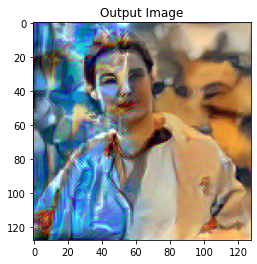

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

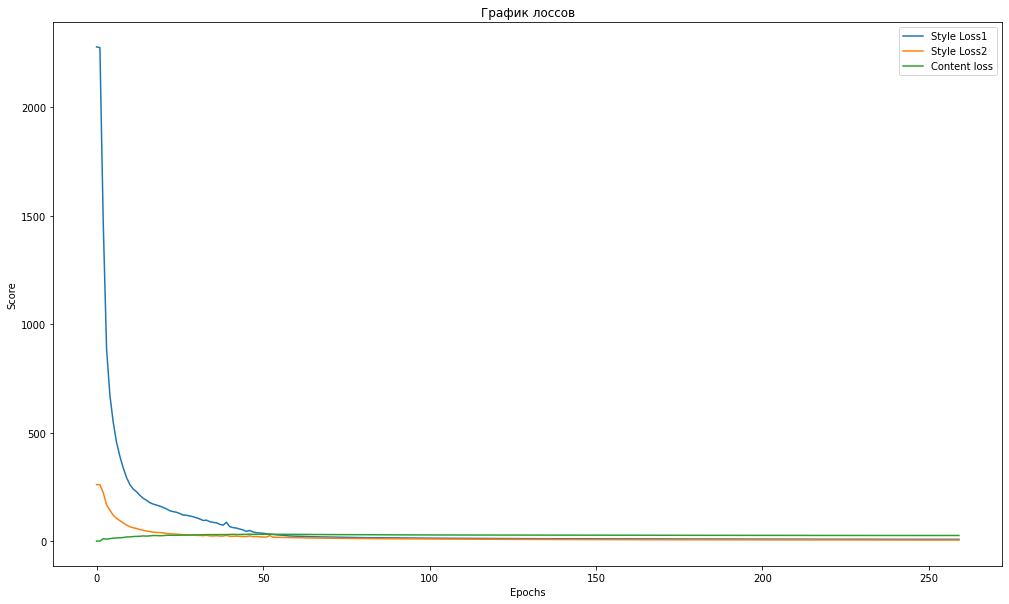

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

### Фигурная маска


ВНИМАНИЕ! В качестве параметра mask_type указываем имя файла с маской до расширения (в кавычках), т.е. если файл был interesting.bmp, то mask_type = 'interesting'

In [ ]:
style1_loss = []
style2_loss = []
content_loss = []

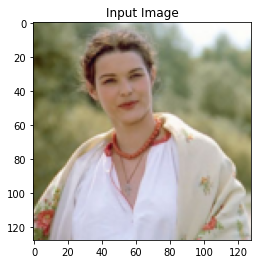

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 38.021004 Style Loss2 : 35.737061 Content Loss: 30.381887

run [100]:
Style Loss1 : 10.376081 Style Loss2 : 19.646206 Content Loss: 27.305117

run [150]:
Style Loss1 : 7.190686 Style Loss2 : 14.651268 Content Loss: 26.106186

run [200]:
Style Loss1 : 5.636199 Style Loss2 : 12.400030 Content Loss: 25.485699

run [250]:
Style Loss1 : 5.024882 Style Loss2 : 11.278648 Content Loss: 25.137487



In [ ]:
input_img = content_img.clone()
# вывод исходной картинки
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, option = 'partial_style', num_steps=250,
                            mask_type='interesting')

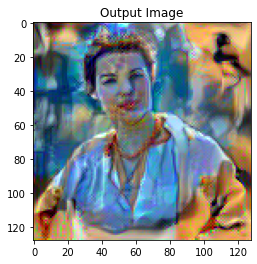

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

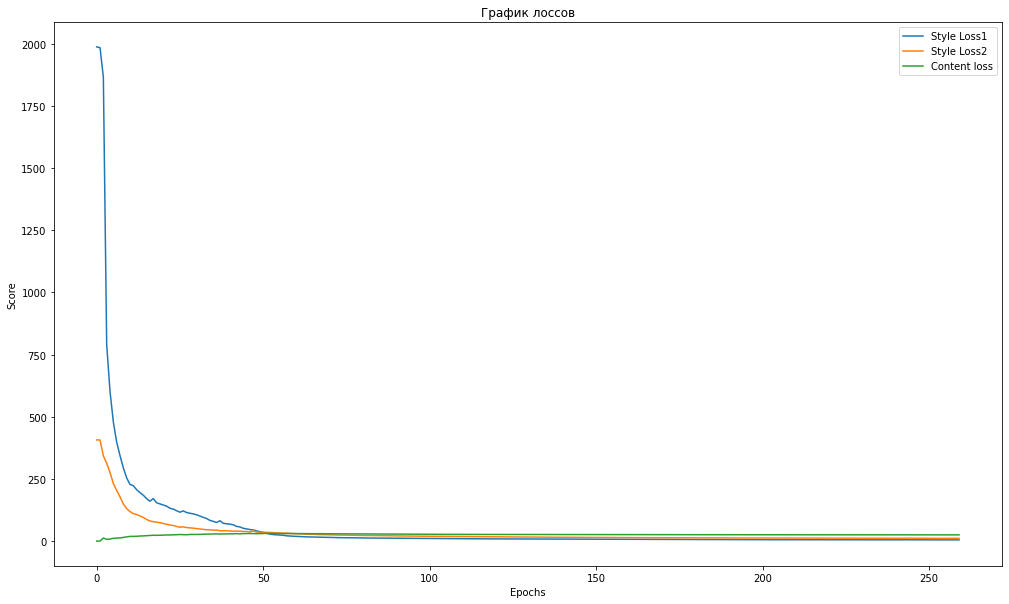

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

### Одновременный перенос двух стилей.

Маски не нужны

In [ ]:
# для отрисовки графиков обучения
style1_loss = []
style2_loss = []
content_loss = []

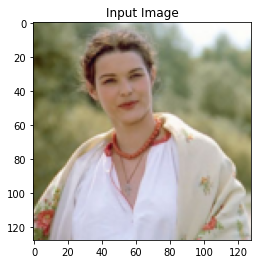

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 354.766937 Style Loss2 : 448.541504 Content Loss: 12.358778

run [100]:
Style Loss1 : 328.118042 Style Loss2 : 453.870422 Content Loss: 10.177268

run [150]:
Style Loss1 : 324.701691 Style Loss2 : 451.703430 Content Loss: 9.513880

run [200]:
Style Loss1 : 321.183746 Style Loss2 : 451.867279 Content Loss: 9.233396

run [250]:
Style Loss1 : 321.665894 Style Loss2 : 449.794739 Content Loss: 8.850713

run [300]:
Style Loss1 : 319.566162 Style Loss2 : 451.214661 Content Loss: 8.548010



In [ ]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, num_steps=300, option = 'dual_style', mask_type = None)

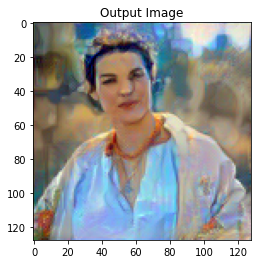

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

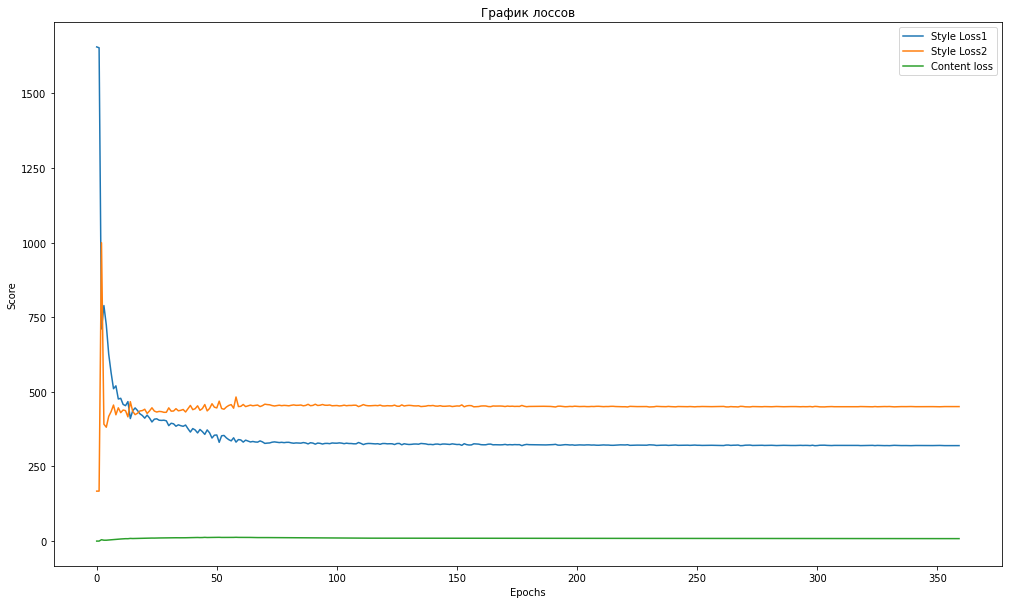

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

### Из шума с вертикальной маской

In [ ]:
style1_loss = []
style2_loss = []
content_loss = []

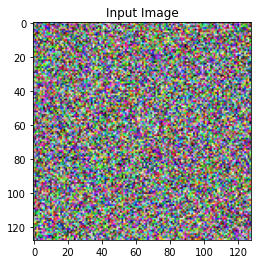

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 29.535242 Style Loss2 : 24.558886 Content Loss: 54.658733

run [100]:
Style Loss1 : 13.647726 Style Loss2 : 11.148054 Content Loss: 46.263683

run [150]:
Style Loss1 : 10.322789 Style Loss2 : 7.583258 Content Loss: 39.654015

run [200]:
Style Loss1 : 8.896976 Style Loss2 : 6.115381 Content Loss: 35.410702

run [250]:
Style Loss1 : 8.248442 Style Loss2 : 5.270370 Content Loss: 32.574543

run [300]:
Style Loss1 : 7.780385 Style Loss2 : 4.785715 Content Loss: 30.708981



In [ ]:
# input_img = content_img.clone()
# из шума
input_img = torch.randn(content_img.data.size(), device=device)
# вывод исходной картинки
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, num_steps=300, option = 'partial_style',
                            mask_type='vert')

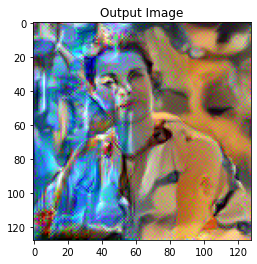

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

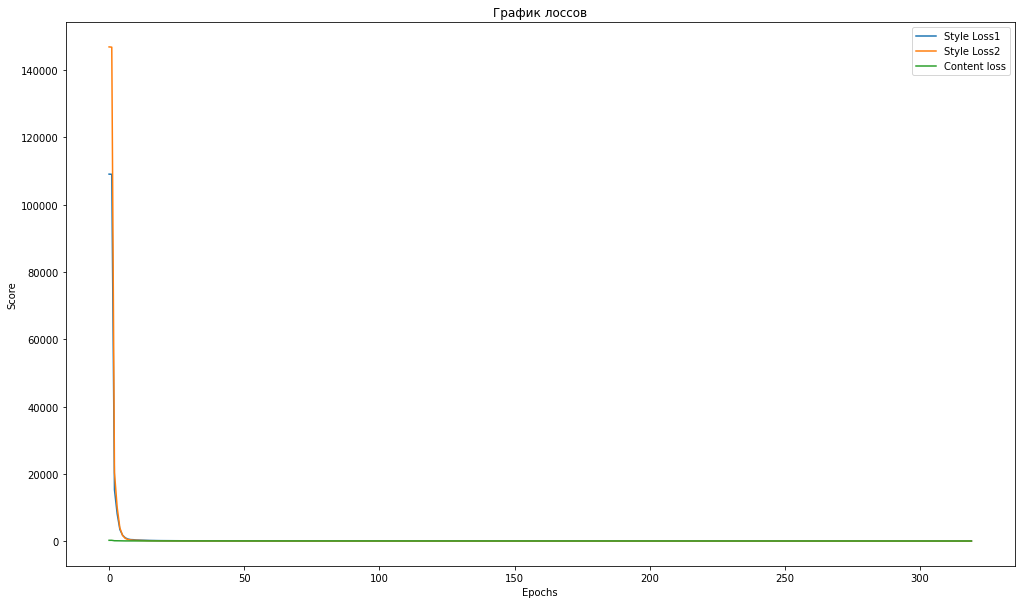

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

### Из шума, одновременный перенос стилей

In [ ]:
style1_loss = []
style2_loss = []
content_loss = []

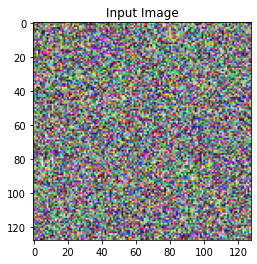

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss1 : 332.017792 Style Loss2 : 472.922760 Content Loss: 35.488476

run [100]:
Style Loss1 : 319.760376 Style Loss2 : 462.362213 Content Loss: 26.767113

run [150]:
Style Loss1 : 319.419525 Style Loss2 : 456.510162 Content Loss: 20.674679

run [200]:
Style Loss1 : 319.969360 Style Loss2 : 453.828369 Content Loss: 16.695087

run [250]:
Style Loss1 : 319.317108 Style Loss2 : 453.384735 Content Loss: 14.323352

run [300]:
Style Loss1 : 319.204651 Style Loss2 : 452.833862 Content Loss: 12.456584

run [350]:
Style Loss1 : 318.877991 Style Loss2 : 452.640808 Content Loss: 11.359922



In [ ]:
# input_img = content_img.clone()
# из шума
input_img = torch.randn(content_img.data.size(), device=device)
# вывод исходной картинки
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, num_steps=350, option = 'dual_style',
                            mask_type=None)

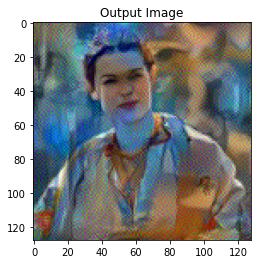

In [ ]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

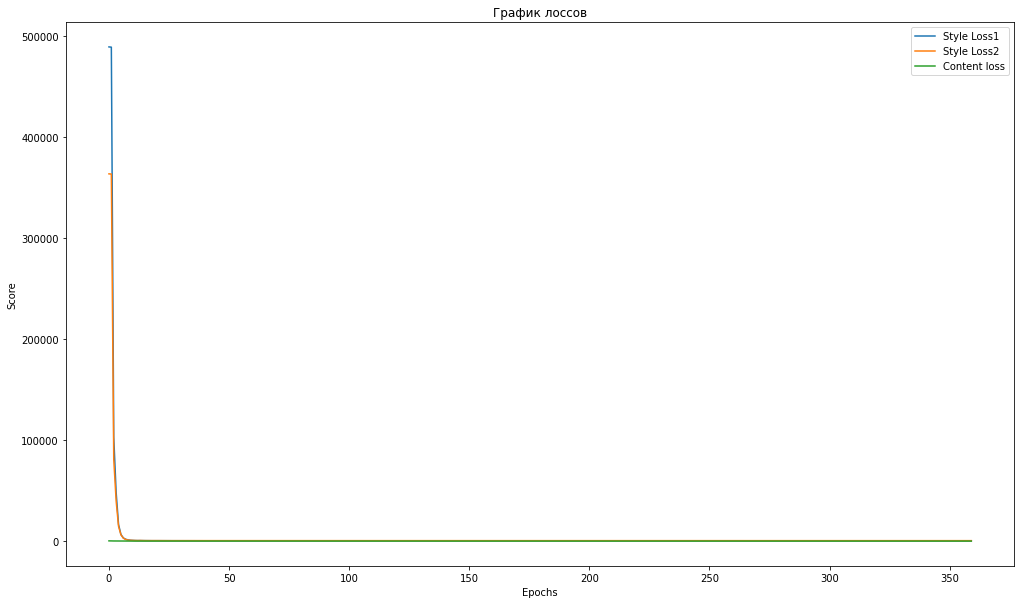

In [ ]:
plt.figure(figsize=(17,10))
plt.plot(style1_loss, label = 'Style Loss1')
plt.plot(style2_loss, label = 'Style Loss2')
plt.plot(content_loss, label = 'Content loss')
plt.title('График лоссов')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

Таким образом, мы перенесли стили разными способами, избегая появления пиков на графиках лоссов.
Получились весьма симпатичные авангардистские картинки :)